# TP 1 : Courbes Intraday et Relations entre des Variables Journalières

Le but de ce TP est de vous familiariser avec la librairie `Pandas` et les bases de données. 

Vous commencerez par construire les courbes intraday moyennes de certains indicateurs de marché tels que le volume, le nombre de trades, le turnover, la volatilité, le spread, l'imbalance ou encore la liquidité disponible aux meilleures limites (best bid et best ask). 

Vous étudierez ensuite les relations entre certains indicateurs journaliers telles que les liens entre le volume et le nombre de trades, le turnover et le nombre de trades et enfin le spread et la volatilité par trade.

## I. Importation et lecture des données

Vous disposez de 10 bases de données au format `DataFrame` de `Pandas`, une pour chaque actif sur 3 bourses différentes :
* **Paris** : Bouygues, LVMH, Sanofi et Total ;
* **Nasdaq** : Amazon, Apple, Google ;
* **Tokyo** : Canon, Panasonic et Sony.

Vous aurez besoin d'importer les librairies Python classiques : `NumPy`, `Pandas`, `MatPlotLib` et `DateTime` pour gérer les dates/heures.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import os

Chaque `DataFrame` présente l'ensemble des transactions pour l'année 2011 pour l'actif et a le même format : 
* l'index `Time` est le timestamp de la transaction ;
* la colonne `TradedPrice` représente le prix moyen par action de la transaction ;
* la colonne `TradedQty` représente le volume de la transaction ;
* la colonne `BidPrice` représente le prix du best bid juste avant la transaction ;
* la colonne `AskPrice` représente le prix du best ask juste avant la transaction ;
* la colonne `BidQty` représente le volume au best bid juste avant la transaction ;
* la colonne `AskQty` représente le volume au best ask juste avant la transaction ;
* la colonne `TradedSign` représente le signe de la transaction (négatif pour Bid et positif pour ask).

L'index `Time` de la série temporelle est au format `DateTime` de Python. Vous pouvez donc extraire les dates, mais aussi l'année, le mois, le jour, l'heure, la minute, etc.

## II. Courbes intraday de différents indicateurs

Vous devez réaliser les courbes intraday moyennes sur l'année par tranches de 5 minutes en pourcentage (pour comparer les actifs) et faire un graphique pour chaque bourse avec les 3 ou 4 actifs de chacune. Vous commenterez ensuite pour chacune de courbes les résultats obtenus (forme de la courbe, pics, etc.).

Vous pourrez utiliser la fonction `resample` de `Pandas` qui vous permet de rééchantillonner à la fréquence souhaitée et de calculer des statistiques à cette fréquence (comme la somme, moyenne, variance, minimum, maximum, etc.).

In [ ]:
def df_process(path, agreg="m", normalize=True):
    df = pd.read_hdf(path)
    
    if agreg == 's' :
        df["NbTrades"] = np.abs(df["TradedSign"])
        df['Volatility'] = df['TradedPrice'].pct_change()**2
        df = df.resample('5min').sum()
        df['Turnover'] = df['TradedPrice'] * df['TradedQty']
        df['Imbalance'] = np.abs(df['AskQty']- df['BidQty'])/(df['AskQty']+df['BidQty'])
        df['SignedImbalance'] = (df['AskQty']- df['BidQty'])/(df['AskQty']+df['BidQty'])
        df['BBOQty'] = df['AskQty'] + df['BidQty']

    elif agreg == 'm' :
        df['Spread'] = (df['AskPrice'] - df['BidPrice']) / df['TradedPrice']
        df['Volatility'] = df['TradedPrice'].pct_change()**2
        df = df.resample('5min').mean()

    elif agreg == 'c' :
        df = df.resample('5min').count()

    df = df.groupby([df.index.hour, df.index.minute]).mean()
    df = df[df['TradedPrice']>0]
    df.index = df.index.map(lambda x: "{:02d}:{:02d}".format(x[0], x[1]))
    if normalize:
        df = df / df.sum()
    return df

dir = "./Data/"

nasdaq_stocks = ["Apple", "Amazon", "Google"]
epa_stocks    = ["Lvmh", "Total", "Bouygues", "Sanofi"]
tyo_stocks    = ["Sony", "Canon", "Panasonic"]

universe = {"Nasdaq": nasdaq_stocks,
            "Paris": epa_stocks,
            "Tokyo": tyo_stocks,
            }

def make_plot(param, agreg, legend):

    fig, axs = plt.subplots(len(universe), 1, figsize=(12, 15))

    for i, (exchange, stocks) in enumerate(universe.items()):
        ax = axs[i]
        for s in stocks:
            df = df_process(dir + s.upper() + '.h5', agreg)
            ax.plot(df.index, df[param], label = s, drawstyle="steps")
        ax.legend()
        ax.set_xticks(df.index[::12])
        ax.grid(alpha=.3)
        ax.set_title(exchange + ": Intraday " + legend)

    plt.tight_layout()
    plt.show()

### 1. Courbes de volume

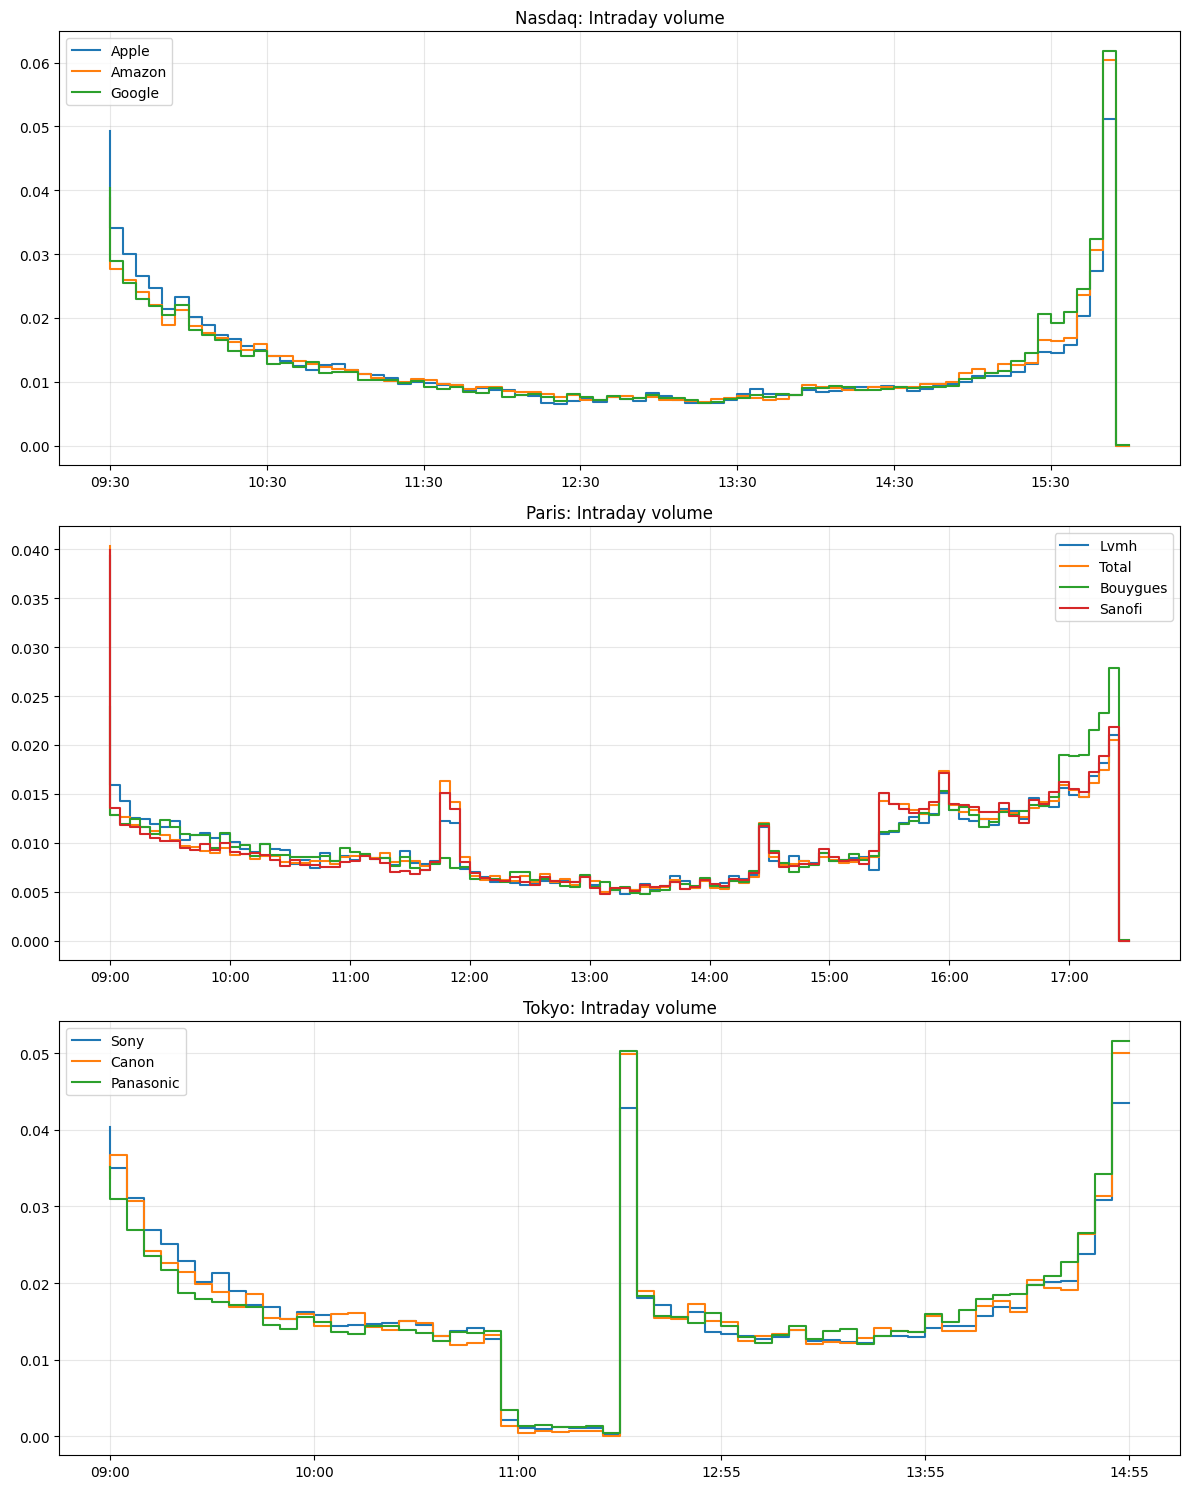

In [4]:
make_plot("TradedQty", "s", "volume")

**Commentaires.**

### 2. Courbes du nombre de trades

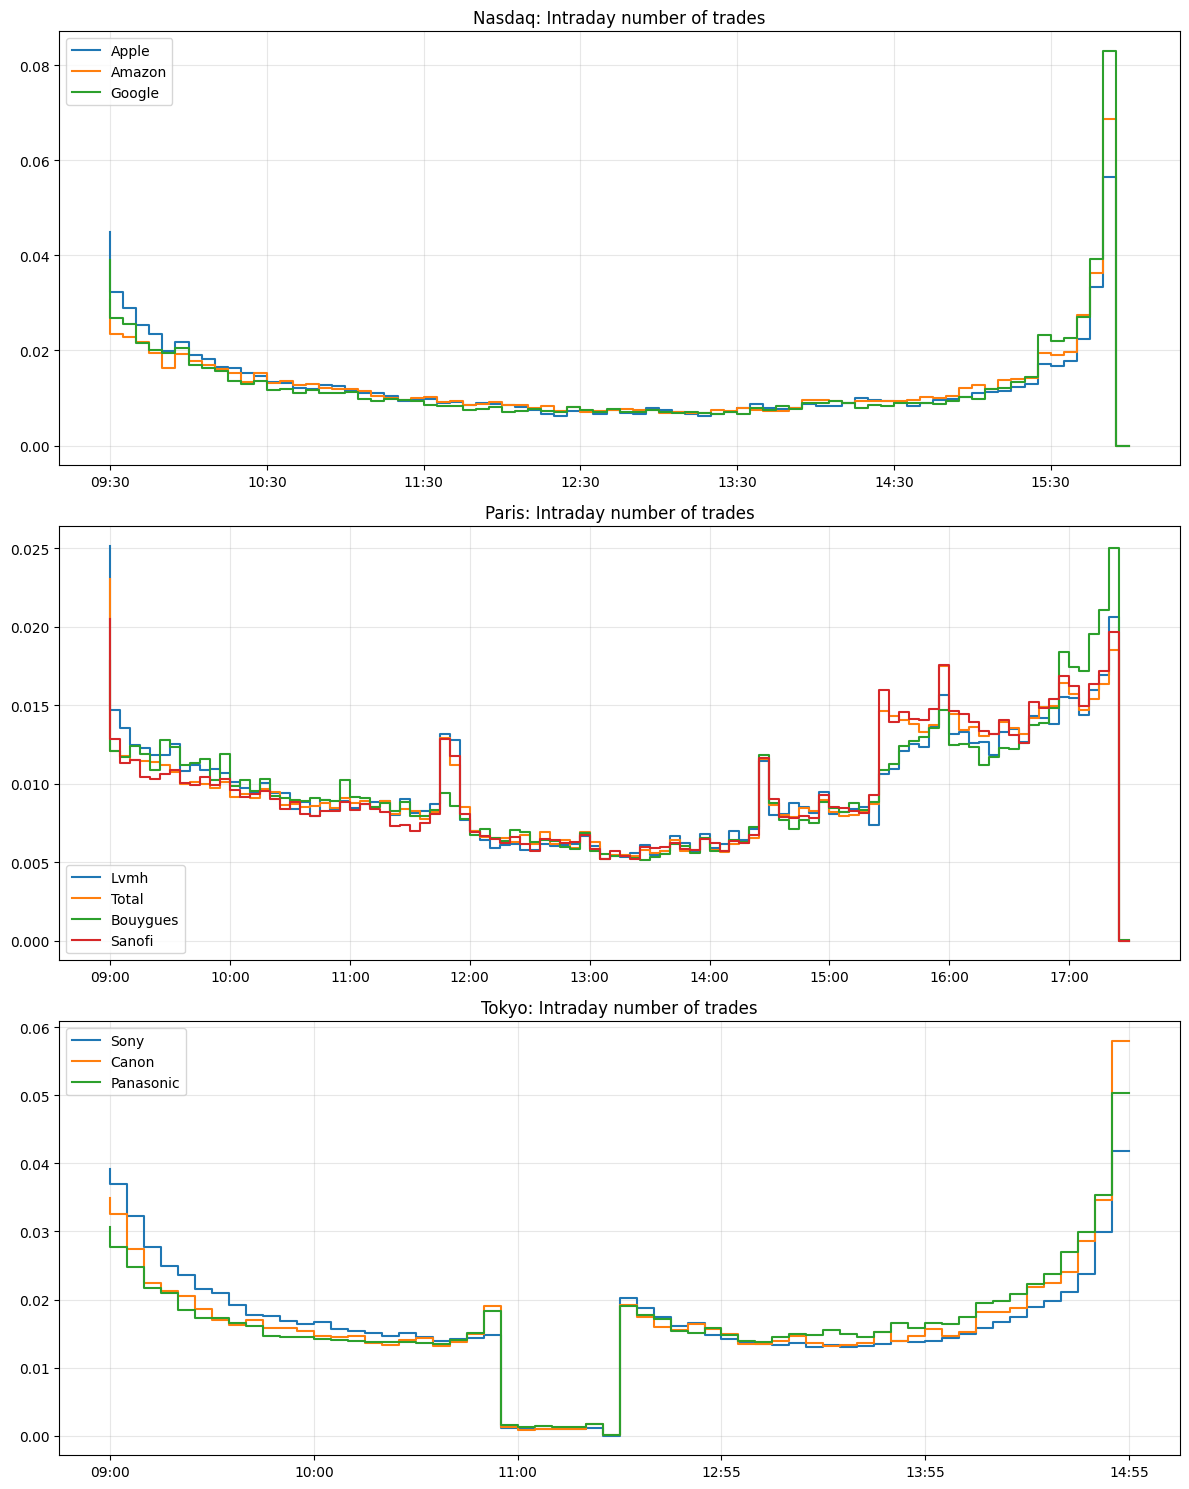

In [5]:
make_plot("NbTrades", "s", "number of trades")

**Commentaires.**

### 3. Courbes de turnover (cash)

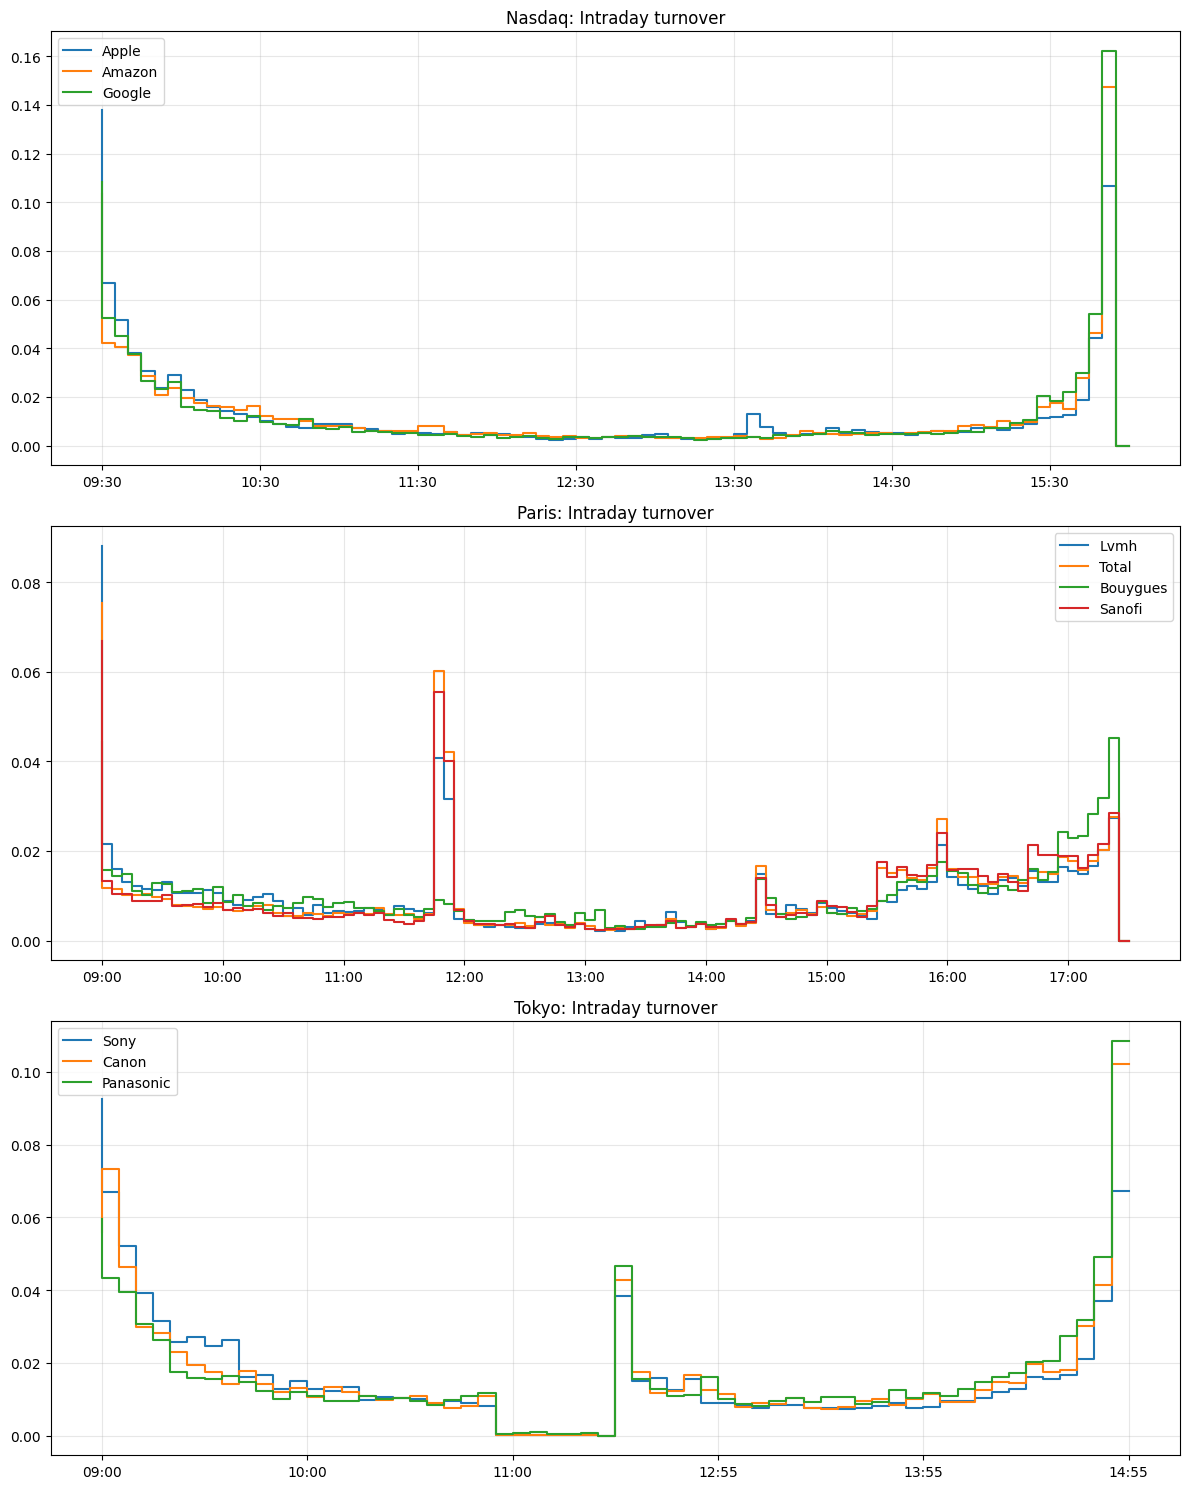

In [6]:
make_plot("Turnover", "s", "turnover")

**Commentaires.**

### 4. Courbes de spread moyen

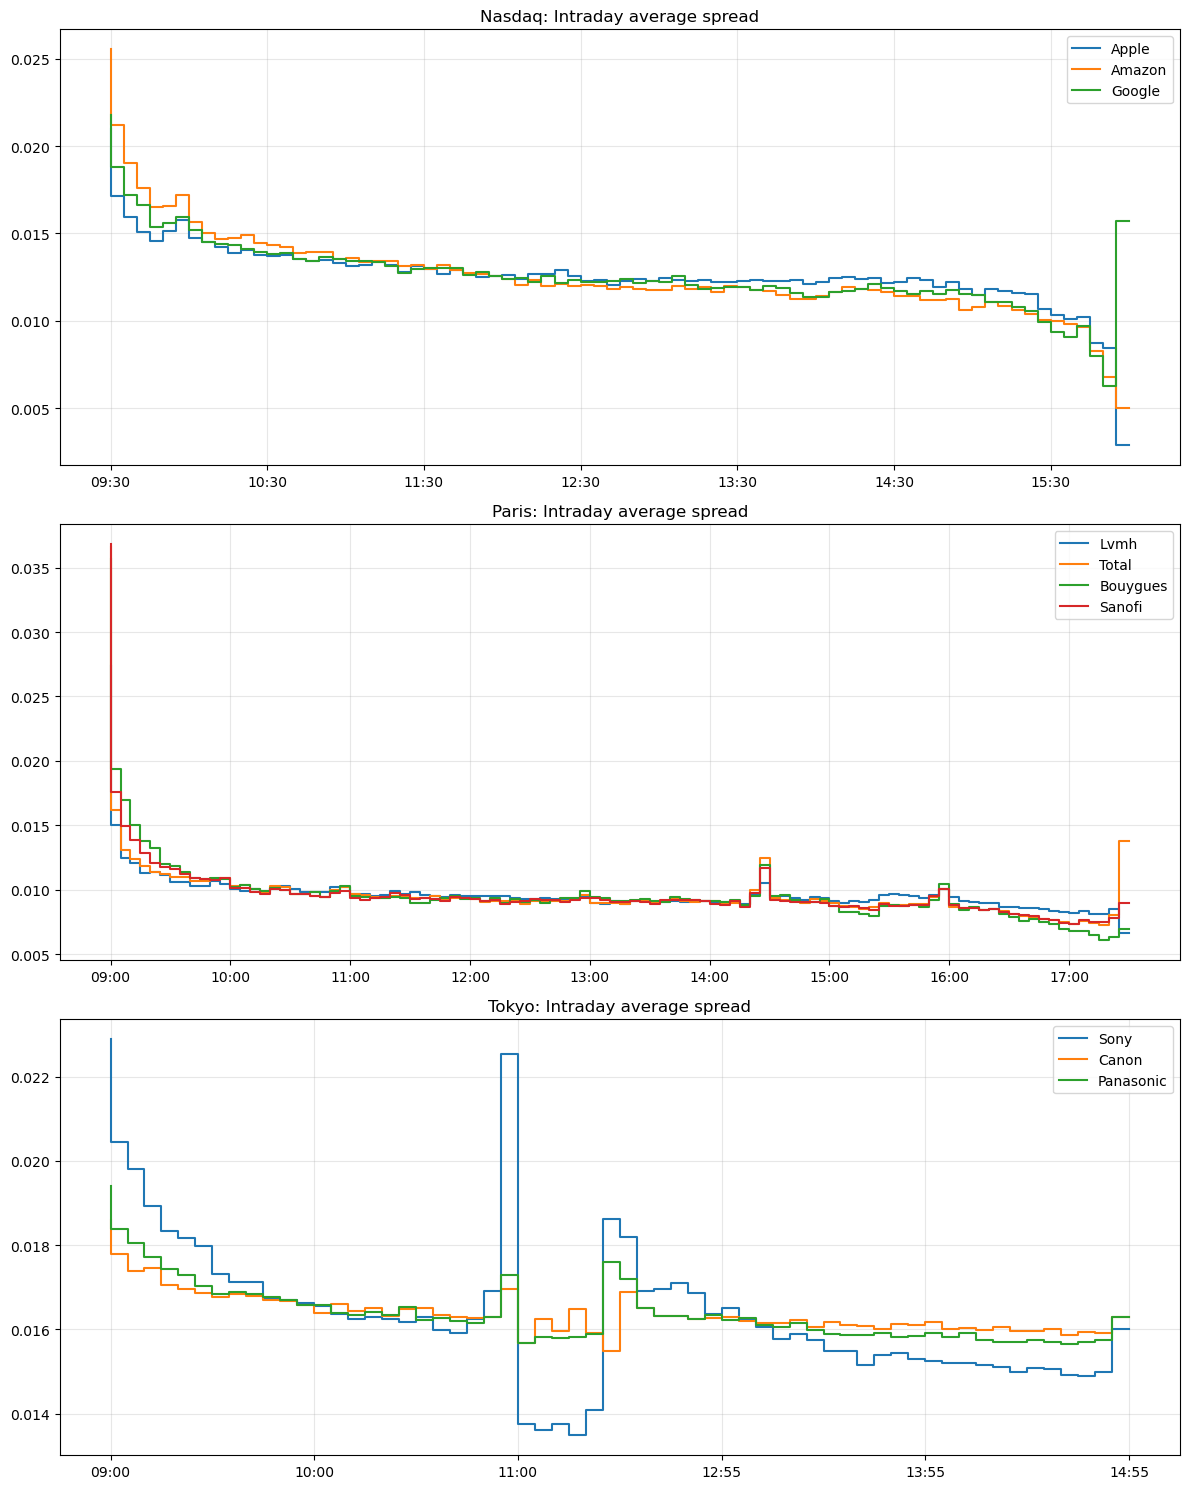

In [79]:
make_plot("Spread", "m", "average spread")

**Commentaires.**

### 5. Courbes de volatilié

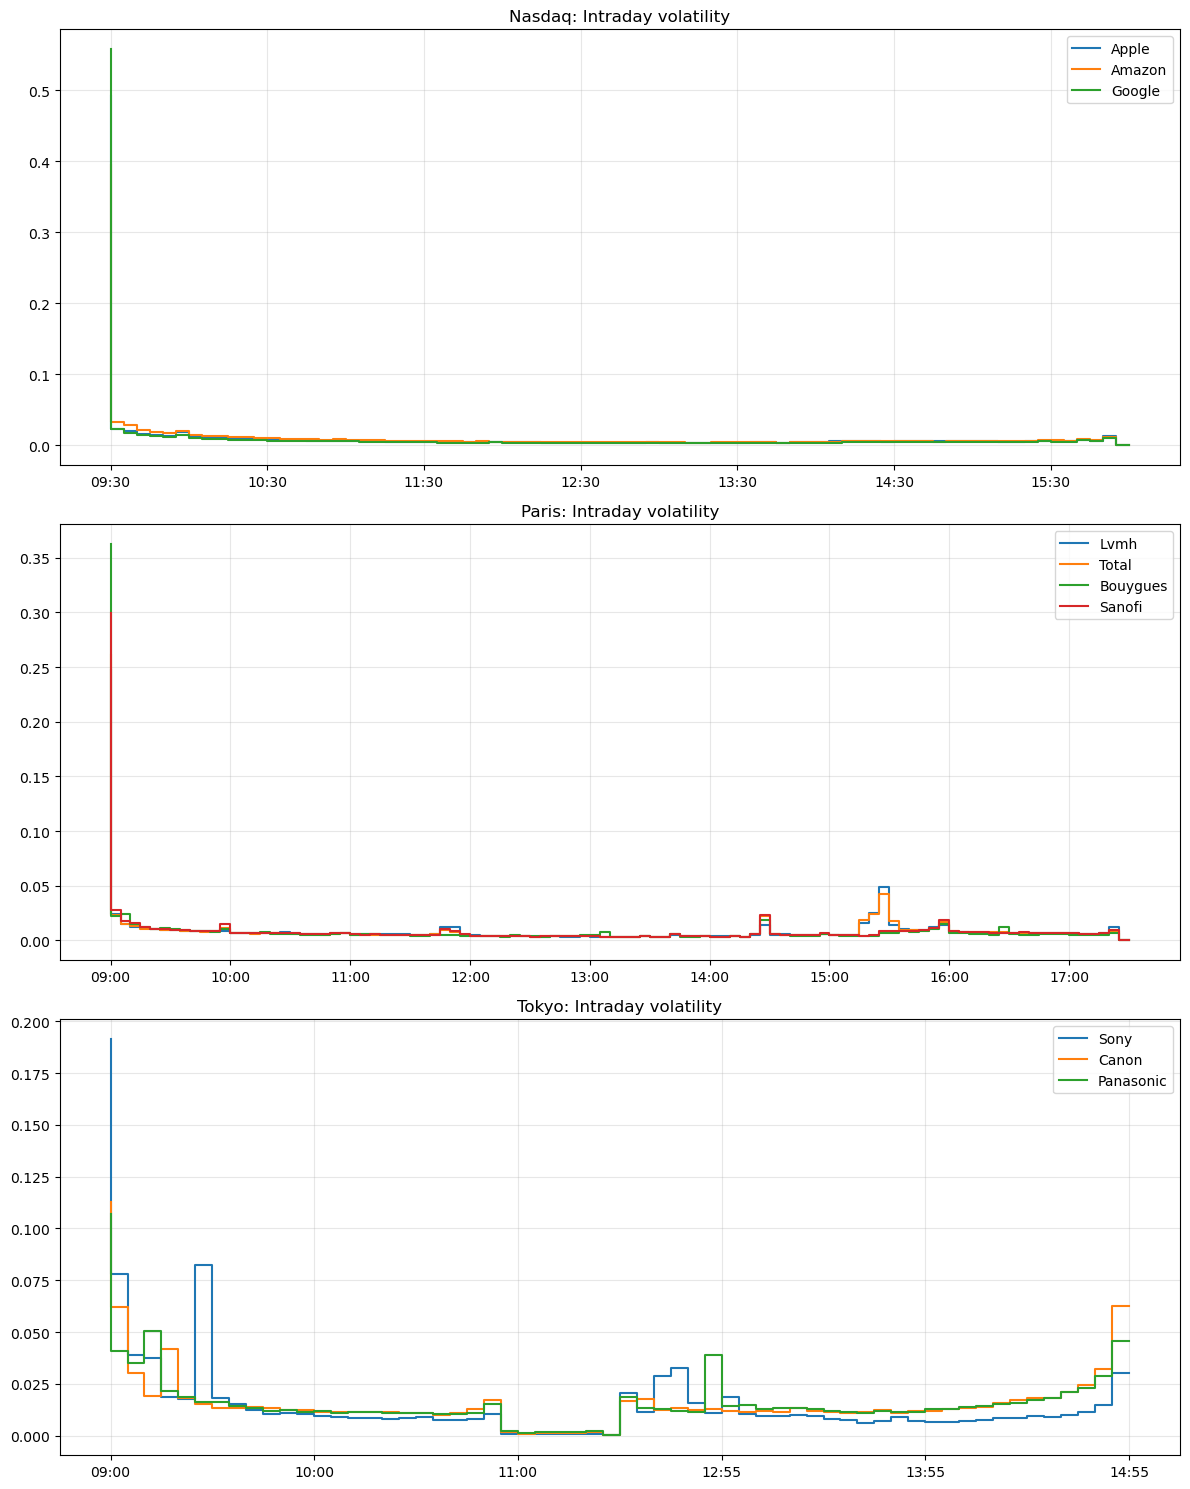

In [80]:
make_plot("Volatility", "s", "volatility")

**Commentaires.**

### 6. Courbes d'imbalance (non signée $|Q_{ask}-Q_{bid}|/(Q_{ask}+Q_{bid})$ ou signée $(Q_{ask}-Q_{bid})/(Q_{ask}+Q_{bid})$)

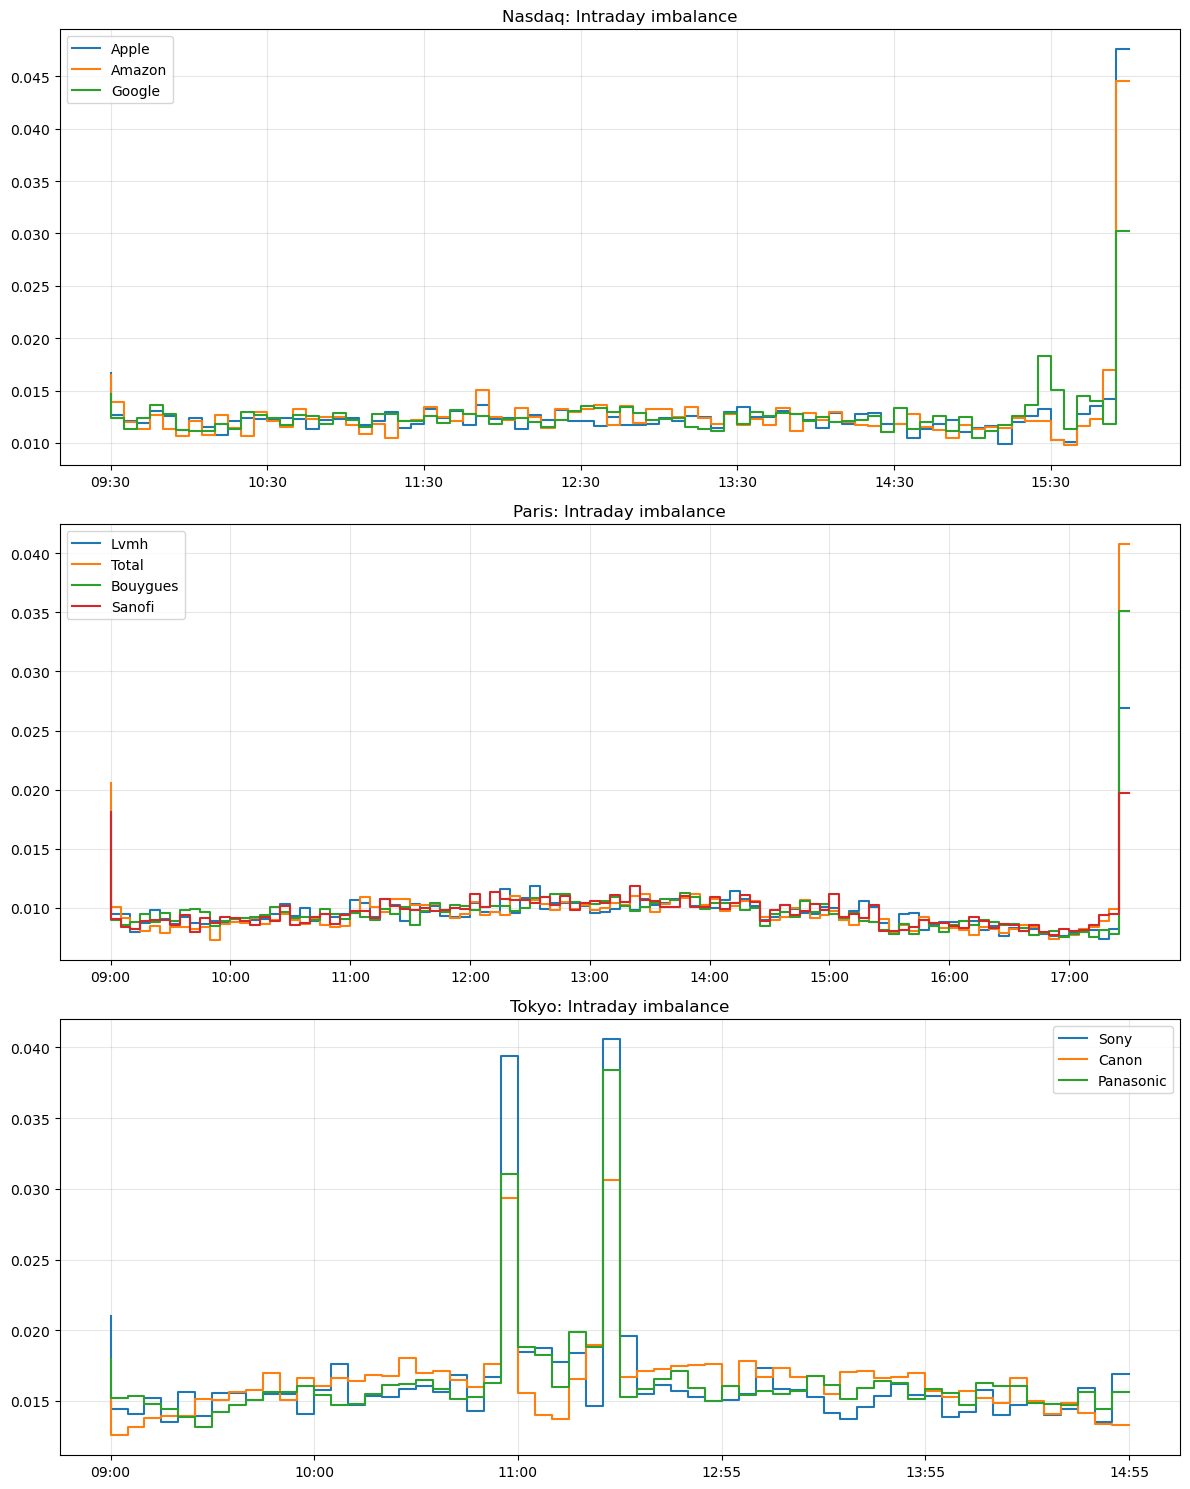

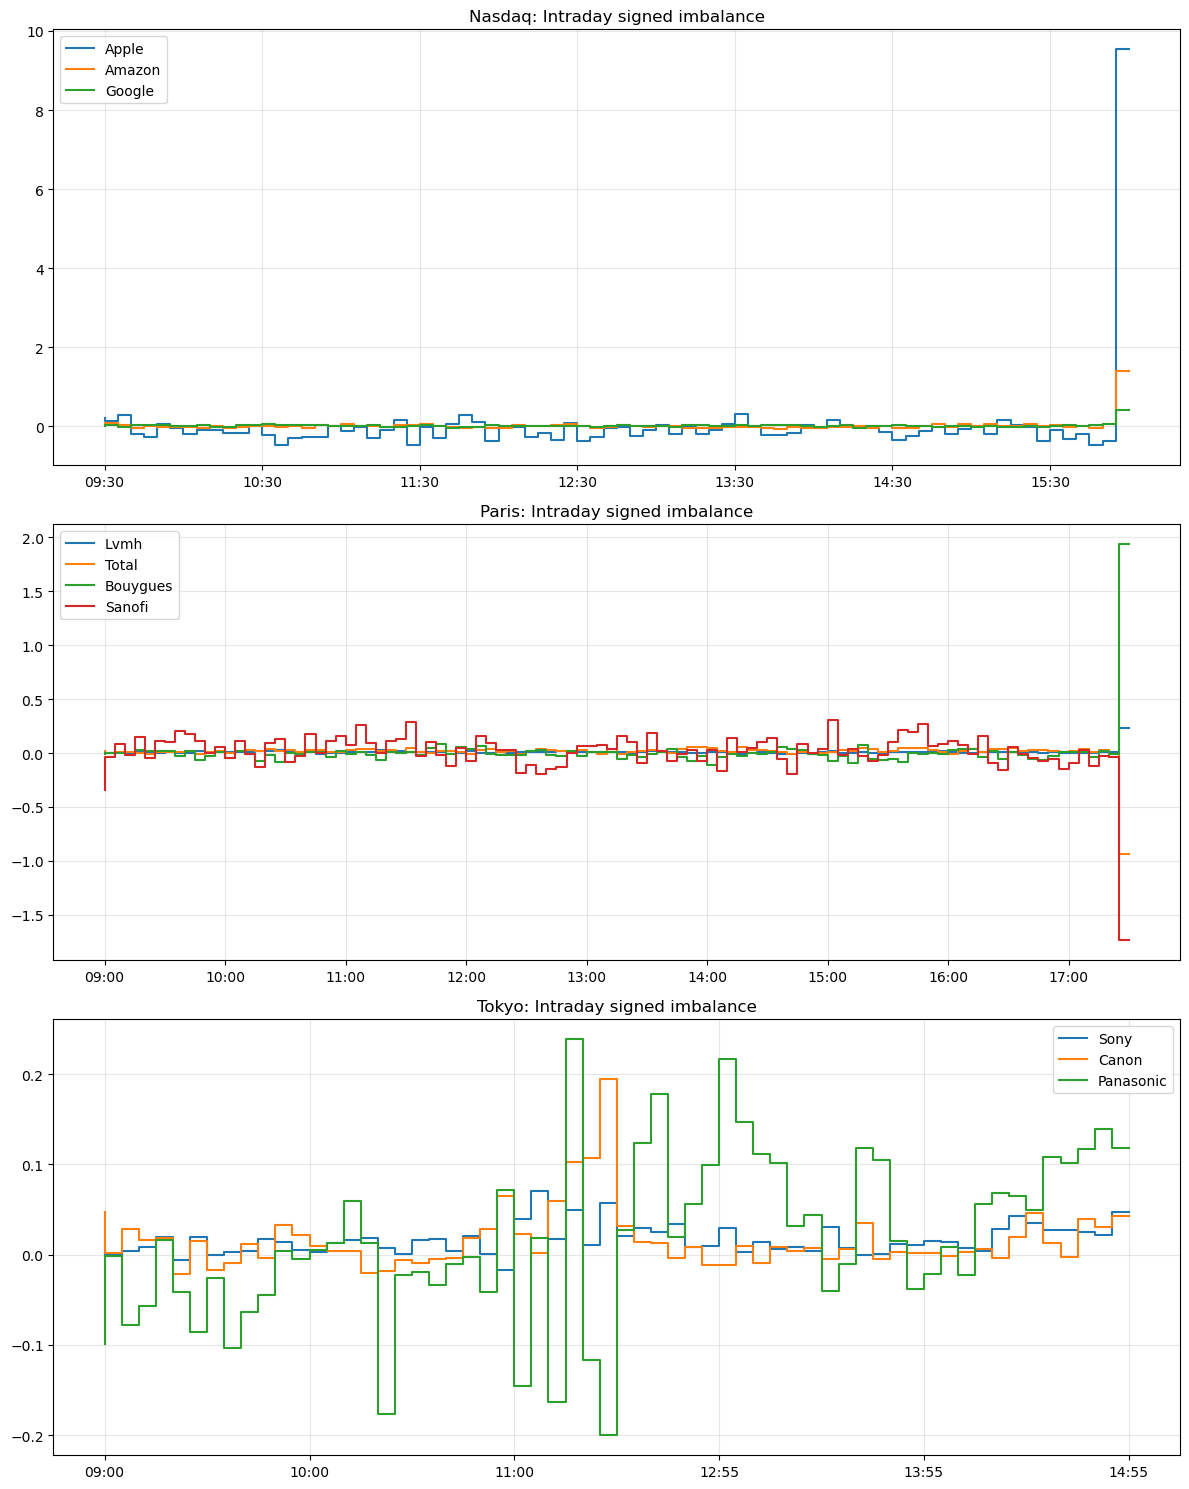

In [83]:
make_plot("Imbalance", "s", "imbalance")
make_plot("SignedImbalance", "s", "signed imbalance")


**Commentaires.**

### 7. Courbes des quantités aux meilleures limites $Q_{ask}+Q_{bid}$

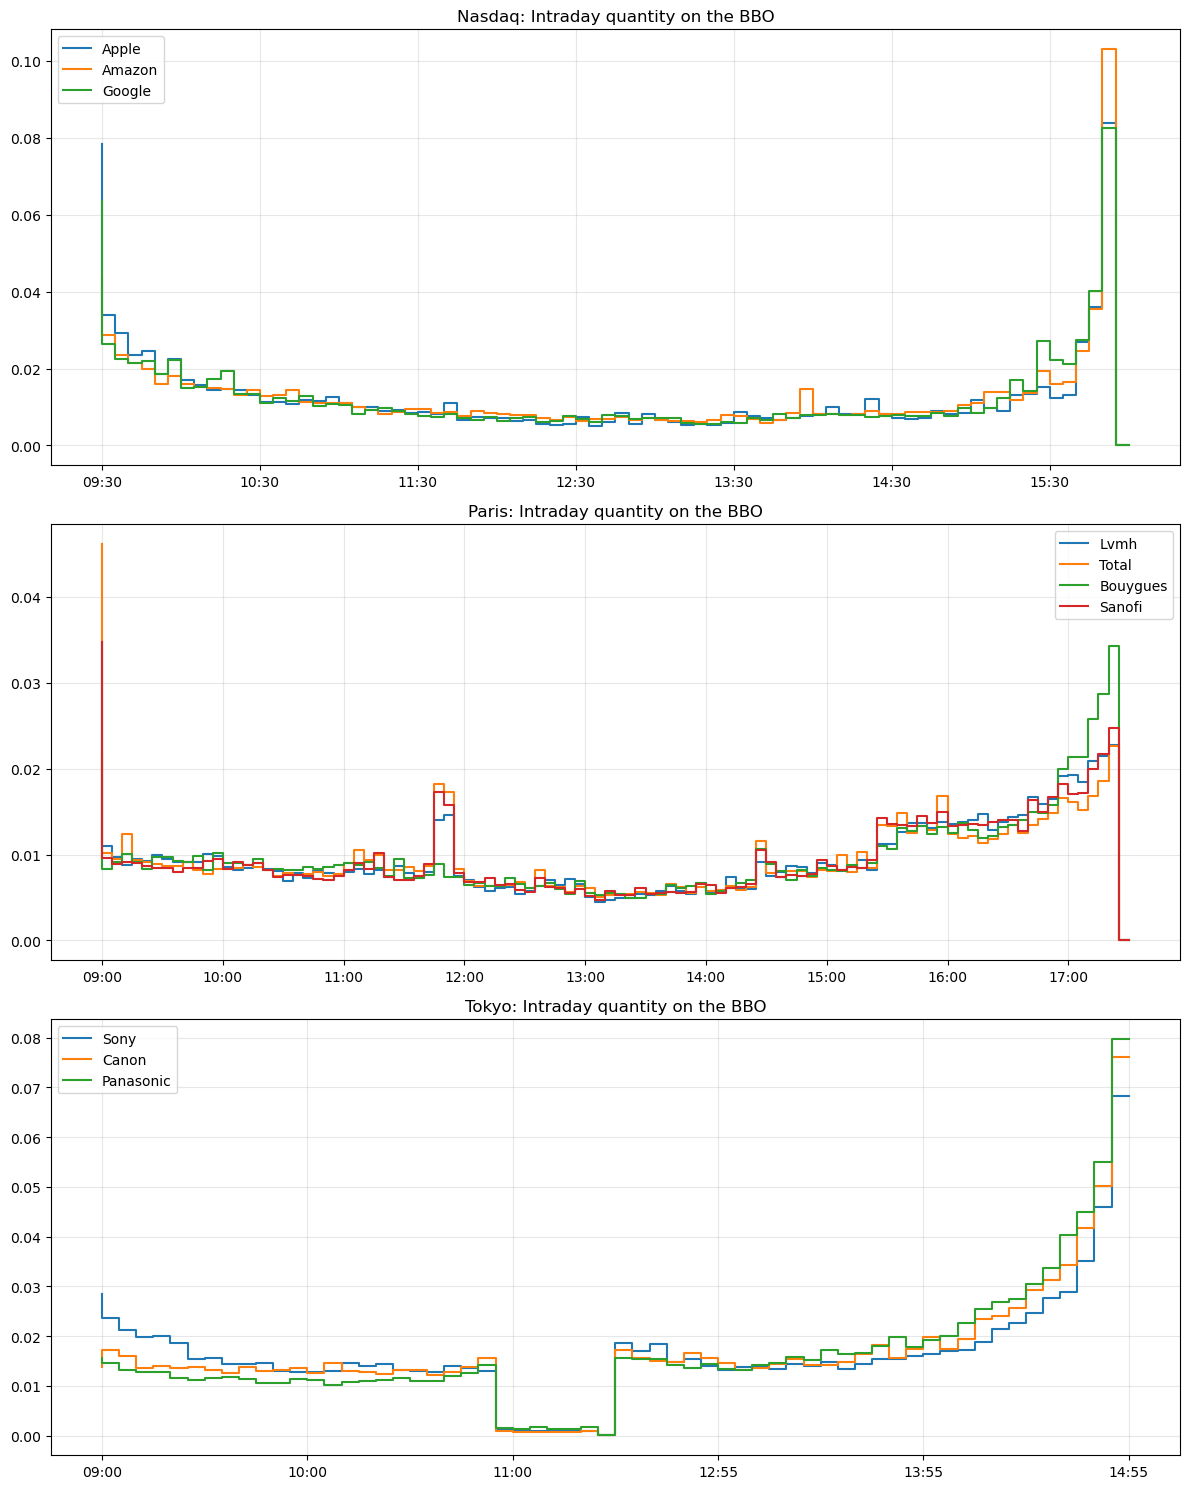

In [85]:
make_plot("BBOQty", "s", "quantity on the BBO")

**Commentaires.**

## III. Relation entre les indicateurs journaliers

Vous allez regarder maintenant la relation entre certains indicateurs journaliers à l'aide de régressions linéaires :
* relation entre les volumes et les nombres de trades, 
* entre les turnovers et les nombres de trades, 
* entre la volatilité par trade et le spread bid-ask.

Comme précédemment, vous ferez un graphique pour chaque bourse avec les 3 ou 4 actifs de chacune. Vous commenterez ensuite pour chacune des relations les résultats obtenus.

In [86]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [151]:
def linreg_plot(predictor, responder, agreg, trendline=True):

    fig, axs = plt.subplots(len(universe), 1, figsize=(12, 15))

    for i, (exchange, stocks) in enumerate(universe.items()):
        ax = axs[i]
        Xs = []
        Ys = []
        for s in stocks:
            df = df_process(dir + s.upper() + '.h5', agreg, normalize=False)
            X = df[predictor].values.reshape(-1, 1)
            Y = df[responder].values.reshape(-1, 1)
            model = LinearRegression()
            model.fit(X, Y)
            ax.scatter(X, Y, label = s, s=5)
            Xs.append(X)
            Ys.append(Y)

        model = LinearRegression()
        model.fit(np.concatenate(Xs), np.concatenate(Ys))

        if trendline:
            Y_pred = model.predict(np.concatenate(Xs))
            ax.plot(np.concatenate(Xs), Y_pred, color="pink", linewidth=1, alpha=.4)
            slope = model.coef_[0][0]
            intercept = model.intercept_[0]
            label = f'Slope: {slope:.2e}, Intercept: {intercept:.2e}'
            ax.text(0.7, 0.1, label, color="pink", transform=ax.transAxes, verticalalignment='top') 
                
        ax.legend()
        ax.grid(alpha=.3)
        ax.set_title(exchange + ":  " + predictor + " --> " + responder)

    plt.tight_layout()
    plt.show()

### 1. Relation volumes/trades

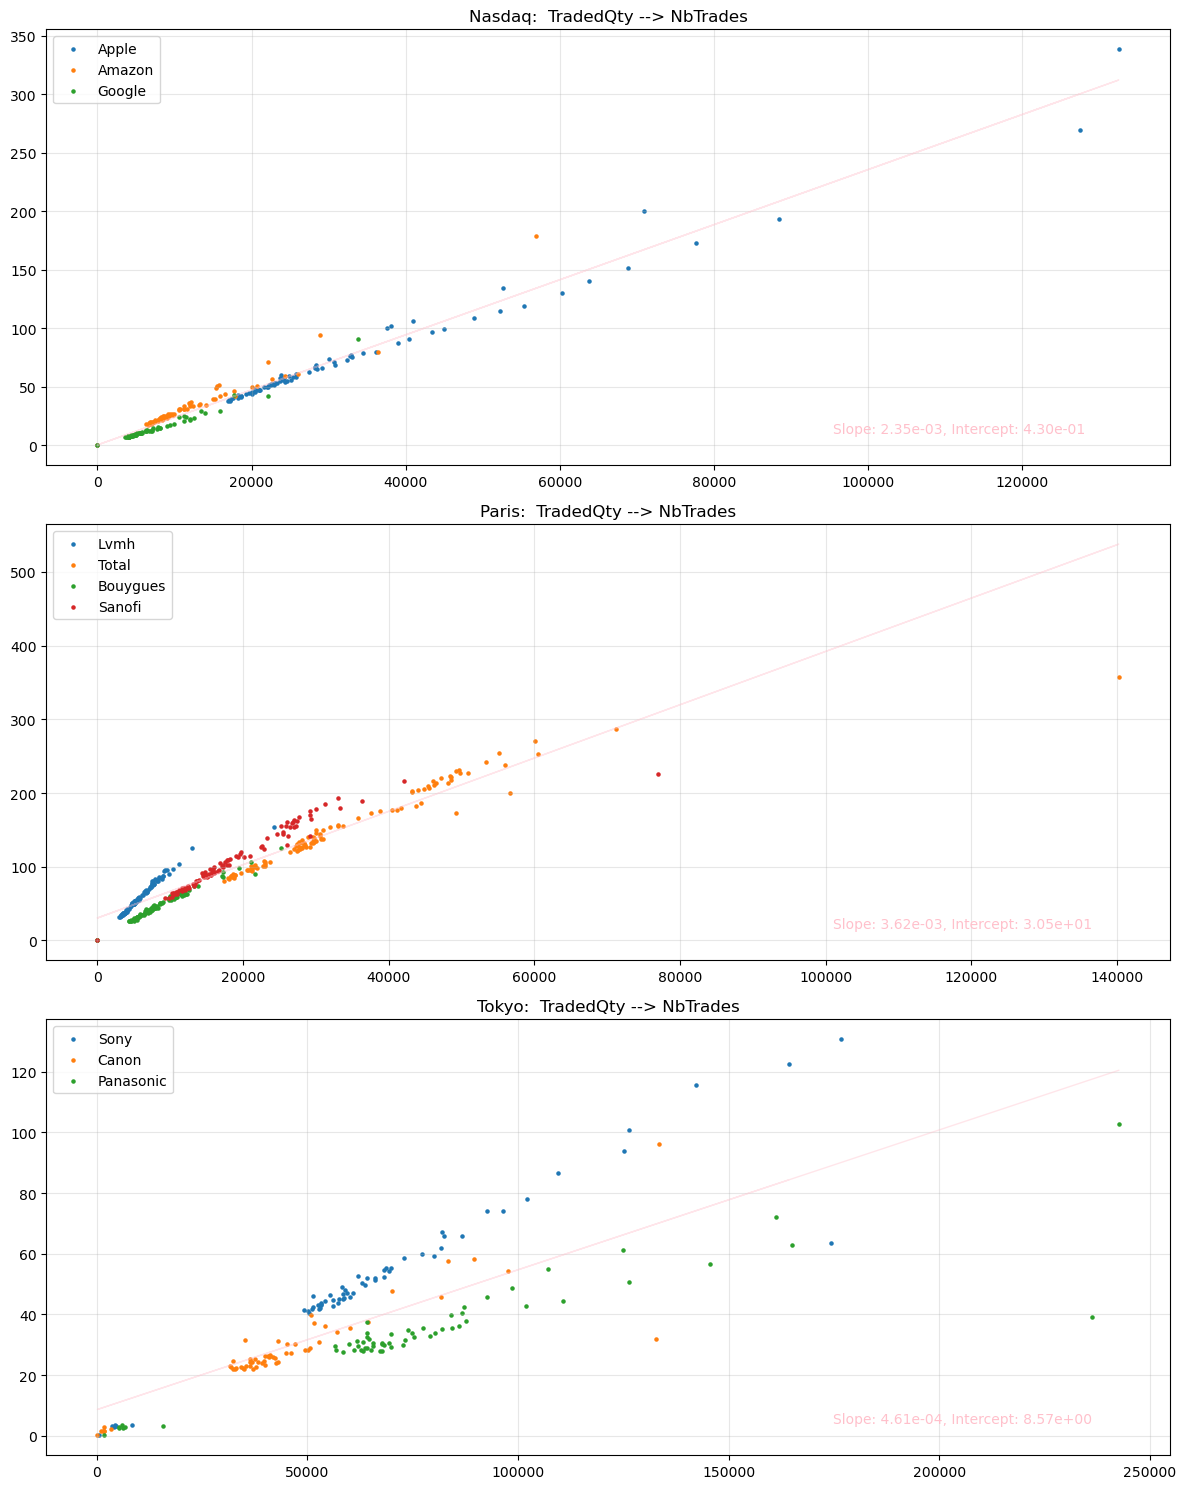

In [152]:
linreg_plot("TradedQty", "NbTrades", 's')

**Commentaires.**

### 2. Relation turnovers/trades

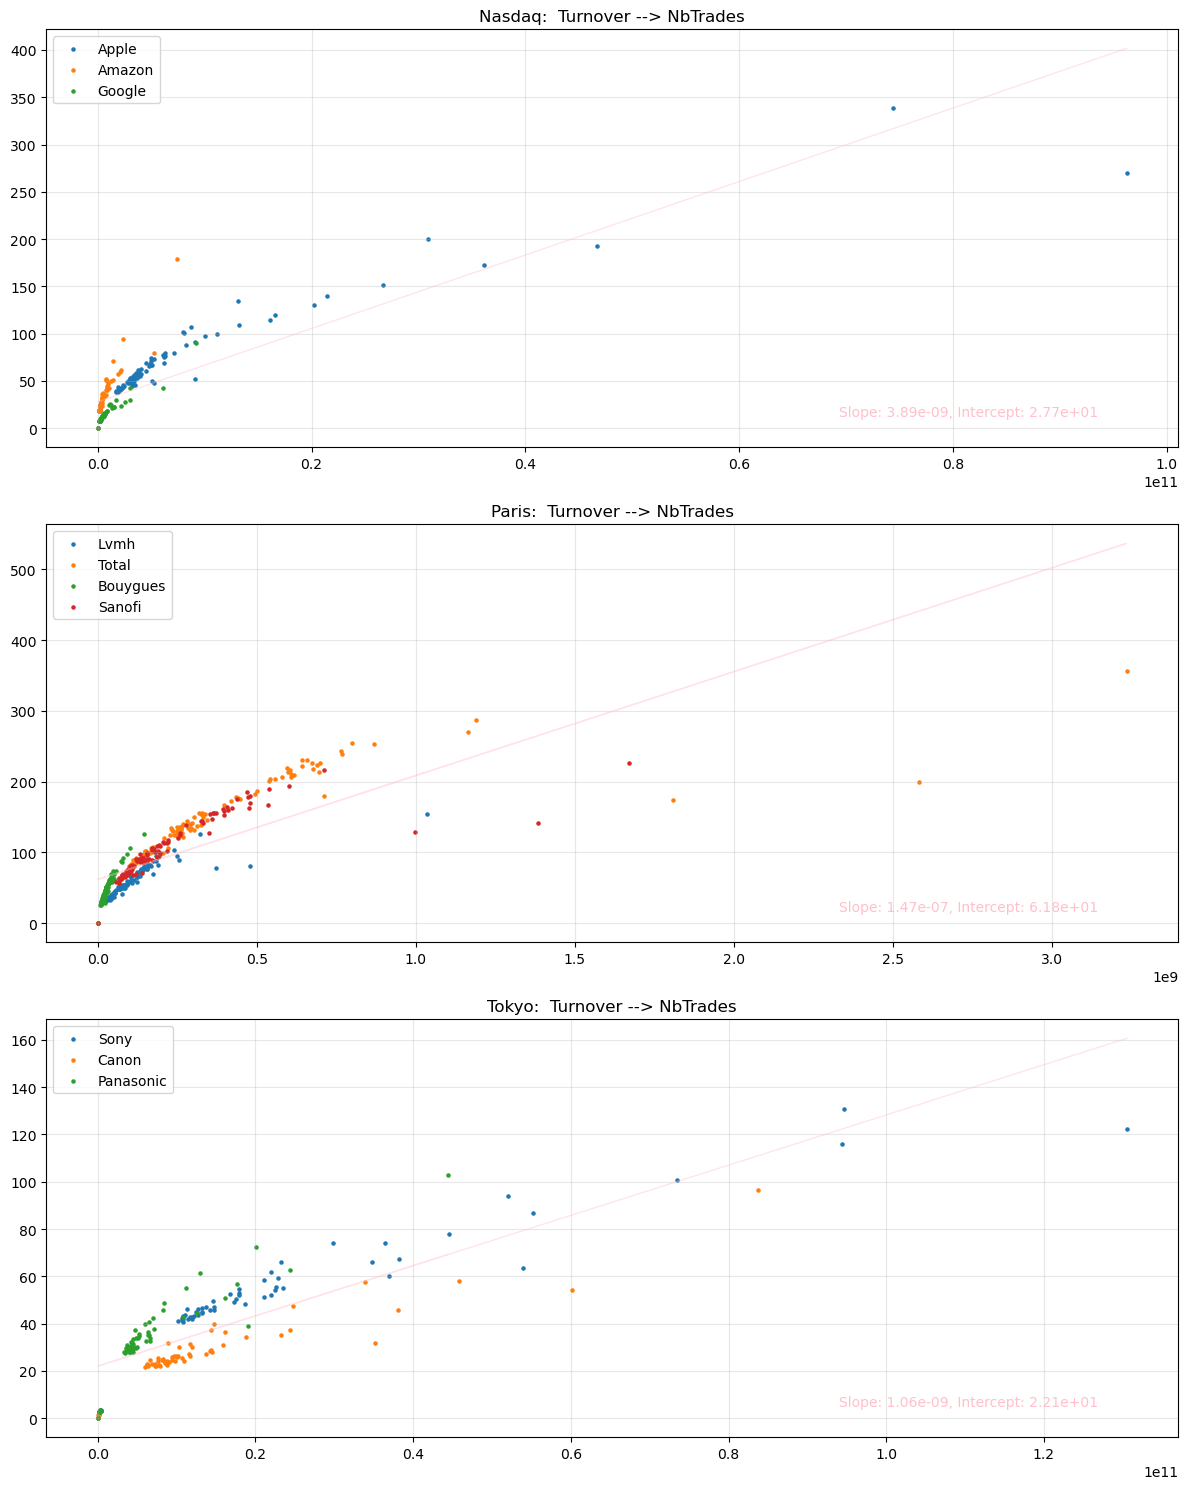

In [153]:
linreg_plot("Turnover", "NbTrades", 's')

**Commentaires.**

### 3. Relation volatilité par trade/bid-ask spread

La volatilité peut être considérée comme une mesure de la quantité d'information contenue dans le prix. En pratique, cette information est corrélée au flux d'ordres qui anticipe ou provoque des mouvements de prix.

Il est bien connu que le spread et la volatilité sont intimement liés : alors que le spread fixe le profit par transaction des market makers, la volatilité détermine la sélection adverse à laquelle ils doivent faire face.
Dans tout modèle où les market makers atteignent leur seuil de rentabilité, il faut avoir une équation fixant la relation entre le spread bid-ask et la volatilité.

Cette relation a fait l'objet de plusieurs modèles essayant de la justifier au niveau microscopique puiqu'elle est obervée empiriquement sur les données.

Dans le modèle le plus simple possible de Madhavan, Richardson et Roomans (MRR) en 1997, on obtient que
$$\varphi=c\sigma_{mid} N^{-1/2},$$
où $\varphi$ est le spread bid-ask, $\sigma_{mid}$ est la volatilité du prix mid, $N$ le nombre de transactions et $c>0$.

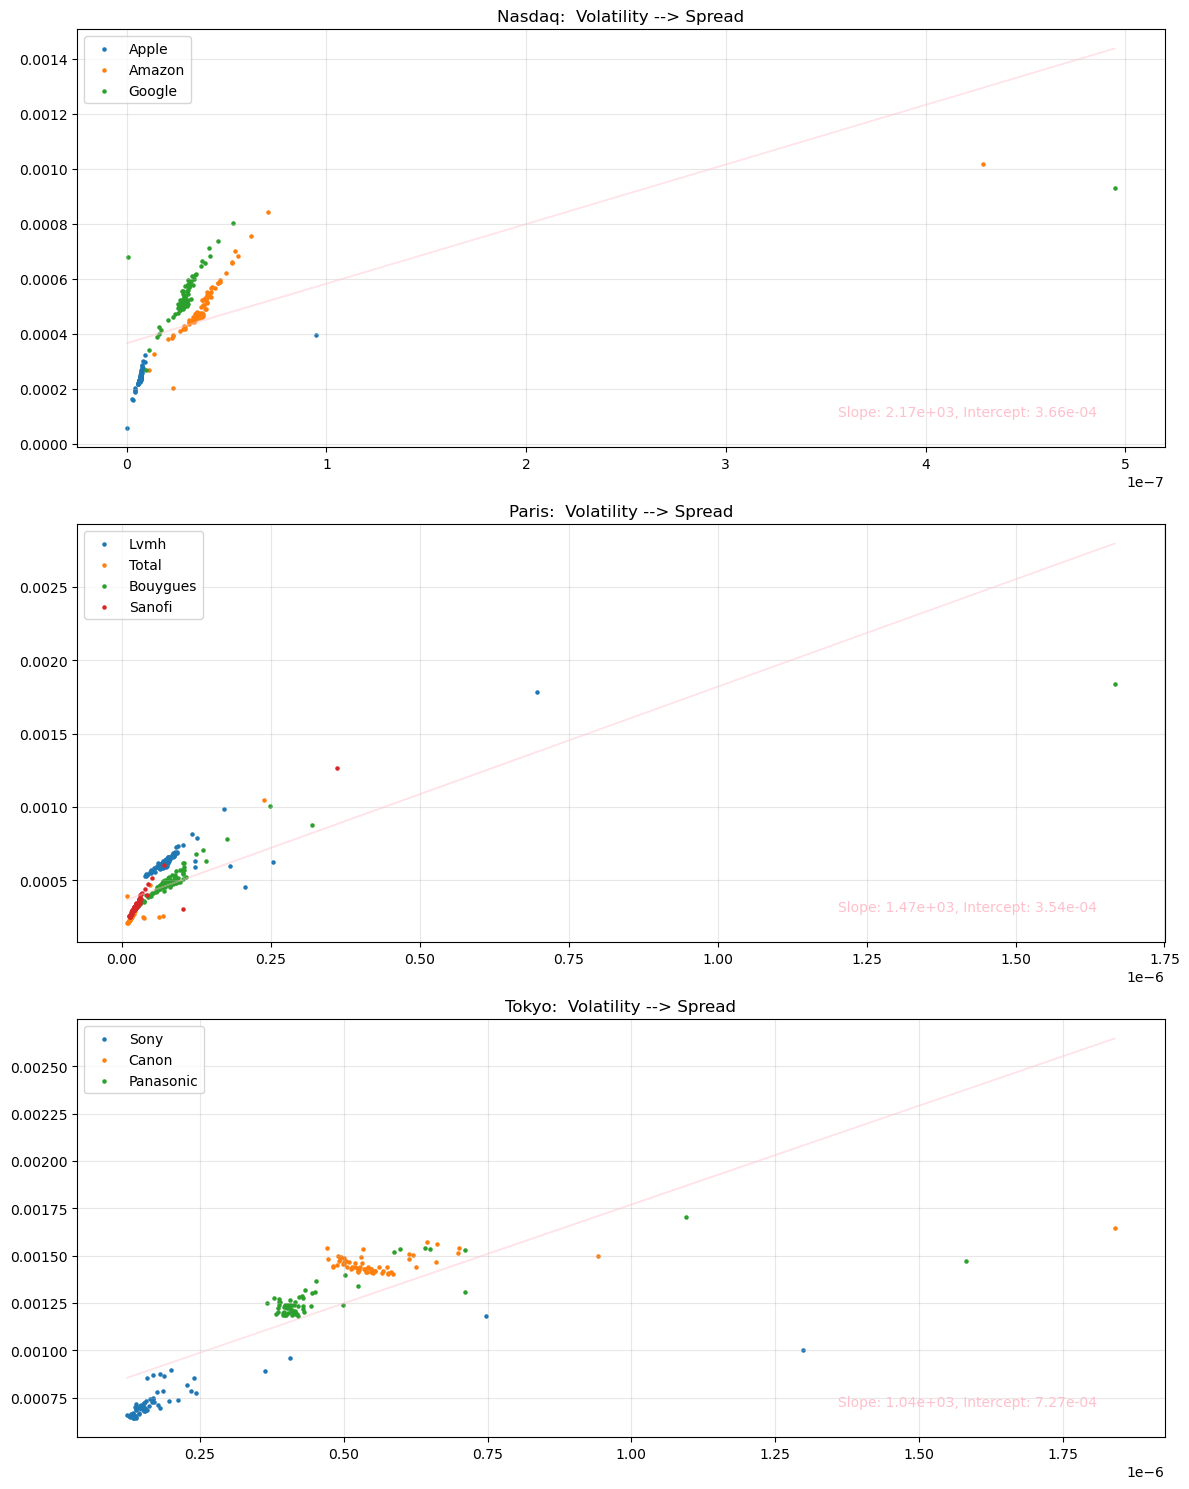

In [154]:
linreg_plot("Volatility", "Spread", 'm')

**Commentaires.**